In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manelfourati","key":"bb56de20ed9465660ea0b820fe10da5a"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c ashrae-energy-prediction

 86% 76.0M/88.4M [00:01<00:00, 43.9MB/s]
100% 88.4M/88.4M [00:01<00:00, 73.2MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 38.6MB/s]
 97% 116M/120M [00:02<00:00, 46.3MB/s]
100% 120M/120M [00:02<00:00, 53.0MB/s]
 94% 156M/167M [00:03<00:00, 43.4MB/s]
100% 167M/167M [00:03<00:00, 48.8MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 168MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 87.2MB/s]


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from numpy import array
import seaborn as sns
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

Using TensorFlow backend.


# **Loading** **Data** 


In [0]:
train_df=pd.read_csv('train.csv.zip', sep=',')
test_df=pd.read_csv('test.csv.zip',sep=',')
building_df=pd.read_csv('building_metadata.csv', sep=',')
weather_train_df=pd.read_csv('weather_train.csv.zip',sep=',')
weather_test_df=pd.read_csv('weather_test.csv.zip',sep=',')

# **Saving Memory_usage**

In [0]:
#To reduce some numeric types 
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
reduce_memory_usage(building_df)
reduce_memory_usage(weather_train_df)
reduce_memory_usage(test_df)
reduce_memory_usage(train_df)
reduce_memory_usage(weather_test_df)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,0,2017-01-01 01:00:00,17.796875,2.0,12.796875,0.0,1022.0,130.0,3.099609
2,0,2017-01-01 02:00:00,16.093750,0.0,12.796875,0.0,1022.0,140.0,3.099609
3,0,2017-01-01 03:00:00,17.203125,0.0,13.296875,0.0,1022.0,140.0,3.099609
4,0,2017-01-01 04:00:00,16.703125,2.0,13.296875,0.0,1022.5,130.0,2.599609
...,...,...,...,...,...,...,...,...,...
277238,15,2018-12-31 19:00:00,3.300781,NaN,1.700195,NaN,1018.5,150.0,7.699219
277239,15,2018-12-31 20:00:00,2.800781,NaN,1.099609,NaN,1018.0,140.0,5.101562
277240,15,2018-12-31 21:00:00,2.800781,NaN,1.700195,-1.0,1017.0,140.0,6.199219
277241,15,2018-12-31 22:00:00,2.800781,NaN,2.199219,8.0,1016.0,140.0,5.101562


# **data** **visualization**



In [0]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [0]:
train_df.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [0]:
train_df.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,1.988706e+03
std,4.269133e+02,9.309921e-01,1.532159e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [0]:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,1.0
1,0,1,Education,2720,2004.0,1.0
2,0,2,Education,5376,1991.0,1.0
3,0,3,Education,23685,2002.0,1.0
4,0,4,Education,116607,1975.0,1.0


In [0]:
building_df.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [0]:
building_df.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.0000,355.000000
mean,6.952381,724.000000,92111.776398,inf,3.740234
std,5.003432,418.434583,110769.950997,31.0625,3.333984
min,0.000000,0.000000,283.000000,1900.0000,1.000000
25%,3.000000,362.000000,23012.000000,1949.0000,1.000000
50%,5.000000,724.000000,57673.000000,1970.0000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.0000,5.000000
max,15.000000,1448.000000,875000.000000,2017.0000,26.000000


In [0]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [0]:
weather_test_df.isnull().sum()

site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
dtype: int64

In [0]:
weather_train_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.0,139660.000000,89484.0,129155.0,133505.0,139469.000000
mean,7.478977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.604744,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
min,0.000000,-28.906250,0.0,-35.000000,-1.0,968.0,0.0,0.000000
25%,3.000000,7.199219,0.0,0.600098,0.0,1012.0,80.0,2.099609
50%,7.000000,15.000000,2.0,8.296875,0.0,1016.5,190.0,3.099609
75%,11.000000,22.203125,4.0,14.398438,0.0,1021.0,280.0,5.000000
max,15.000000,47.187500,9.0,26.093750,343.0,1046.0,360.0,19.000000


In [0]:
weather_test_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,0,2017-01-01 01:00:00,17.796875,2.0,12.796875,0.0,1022.0,130.0,3.099609
2,0,2017-01-01 02:00:00,16.093750,0.0,12.796875,0.0,1022.0,140.0,3.099609
3,0,2017-01-01 03:00:00,17.203125,0.0,13.296875,0.0,1022.0,140.0,3.099609
4,0,2017-01-01 04:00:00,16.703125,2.0,13.296875,0.0,1022.5,130.0,2.599609


In [41]:
print('Size of train_df data', train_df.shape)
print('Size of test_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_df data', building_df.shape)

Size of train_df data (20216100, 4)
Size of test_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_df data (1449, 6)


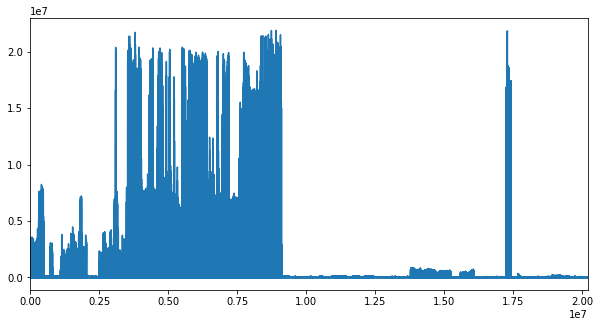

In [0]:
plt.figure(figsize = (10,5))
train_df['meter_reading'].plot()

# **Preparation for weather_data**

In [0]:
#dealing with missing values in weather_df
from sklearn.impute import SimpleImputer #function to fill missing values with another value
cols_with_missing_weather_train = [col for col in weather_train_df.columns if weather_train_df[col].isnull().any()]
imp_most = SimpleImputer(strategy='most_frequent') #fill missing data with the most frequent value
weather_train_df[cols_with_missing_weather_train] = imp_most.fit_transform(weather_train_df[cols_with_missing_weather_train])

In [0]:
weather_train_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000
mean,7.478977,14.418337,1.085625,7.352269,0.629356,1016.145196,172.431070,3.557339
std,4.604744,10.624583,2.137058,9.786547,6.788452,7.334961,115.220234,2.334236
min,0.000000,-28.906250,0.000000,-35.000000,-1.000000,968.000000,0.000000,0.000000
25%,3.000000,7.199219,0.000000,0.600098,0.000000,1012.000000,70.000000,2.099609
50%,7.000000,15.000000,0.000000,8.296875,0.000000,1016.000000,180.000000,3.099609
75%,11.000000,22.203125,2.000000,14.398438,0.000000,1020.500000,270.000000,5.000000
max,15.000000,47.187500,9.000000,26.093750,343.000000,1046.000000,360.000000,19.000000


In [0]:
#scaling the weather_df features
weather_features_scaling = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_speed','precip_depth_1_hr']
for i in weather_features_scaling:
  mean=weather_train_df[i].mean(axis=0)
  std=weather_train_df[i].std(axis=0)
  weather_train_df[i] = weather_train_df[i].astype('float32')
  weather_train_df[i]=(weather_train_df[i]-mean)/std

In [0]:
weather_train_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000,1.397730e+05
mean,7.478977,-0.000030,0.000045,0.000004,0.000009,-0.000001,172.431070,-2.064681e-07
std,4.604744,0.999987,1.000303,0.999985,0.999758,0.999967,115.220234,1.000128e+00
min,0.000000,-4.077768,-0.508000,-4.327601,-0.240019,-6.563797,0.000000,-1.523985e+00
25%,3.000000,-0.679473,-0.508000,-0.689944,-0.092710,-0.565129,70.000000,-6.244999e-01
50%,7.000000,0.054747,-0.508000,0.096521,-0.092710,-0.019796,180.000000,-1.960942e-01
75%,11.000000,0.732715,0.427866,0.719985,-0.092710,0.593704,270.000000,6.180440e-01
max,15.000000,3.084277,3.703397,1.915025,50.434273,4.070205,360.000000,6.615724e+00


# **Preparation for building data**

In [0]:
#dealing with missing values in _df
from sklearn.impute import SimpleImputer
imp_most = SimpleImputer(strategy='most_frequent') #fill missing data with the most frequent value
cols_with_missing_building_values = [col for col in building_df.columns if building_df[col].isnull().any()]

In [0]:
building_df.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,6.952381,724.000000,92111.776398,1972.253278,1.671498
std,5.003432,418.434583,110769.950997,21.563507,2.026692
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1975.000000,1.000000
50%,5.000000,724.000000,57673.000000,1976.000000,1.000000
75%,13.000000,1086.000000,115676.000000,1976.000000,1.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [0]:
#scaling the building_df features
building_features_scaling = ['square_feet', 'year_built', 'floor_count']
for i in building_features_scaling:
  mean=building_df[i].mean(axis=0)
  std=building_df[i].std(axis=0)
  building_df[i] = building_df[i].astype('float32')
  building_df[i]=(building_df[i]-mean)/std

In [0]:
building_df.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1.449000e+03,1.449000e+03,1.449000e+03
mean,6.952381,724.000000,-8.002690e-09,-9.438019e-07,-7.823469e-07
std,5.003432,418.434583,9.999999e-01,9.999917e-01,9.999916e-01
min,0.000000,0.000000,-8.290043e-01,-3.350721e+00,-3.313269e-01
25%,3.000000,362.000000,-6.238133e-01,1.273774e-01,-3.313269e-01
50%,5.000000,724.000000,-3.109036e-01,1.737521e-01,-3.313269e-01
75%,13.000000,1086.000000,2.127312e-01,1.737521e-01,-3.313269e-01
max,15.000000,1448.000000,7.067695e+00,2.075113e+00,1.200404e+01


In [0]:
#dealing with categorical feature primary_use
building_df = pd.get_dummies(building_df, columns=['primary_use'])

# **Preparation for train data**

In [0]:
weather_train_df.timestamp = pd.to_datetime(weather_train_df.timestamp, format="%Y-%m-%d %H:%M:%S")

In [0]:
train_df.timestamp = pd.to_datetime(train_df.timestamp, format="%Y-%m-%d %H:%M:%S")

In [0]:
#Using the timestamp attribut to add 4 new columns that represent the month , weekday,year and hour
train_df['month'] =train_df['timestamp'].dt.month
train_df['day'] =train_df['timestamp'].dt.weekday
train_df['year'] =train_df['timestamp'].dt.year
train_df['hour'] = train_df['timestamp'].dt.hour

In [0]:
#normalisation and scaling for the target 
train_df['meter_reading'] = np.log1p(train_df['meter_reading'])
#scaling
mean=train_df['meter_reading'].mean(axis=0)
std=train_df['meter_reading'].std(axis=0)
train_df['meter_reading'] = train_df['meter_reading'].astype('float32')
train_df['meter_reading']=(train_df['meter_reading']-mean)/std


In [0]:
#dealing with the categorical feature meter
train_df = pd.get_dummies(train_df, columns=['meter'])

# **Merging data**

In [0]:
X_train=train_df

In [0]:
X_train= X_train.merge(building_df, on="building_id", how="left") 

In [0]:
X_train = pd.merge_asof(X_train, weather_train_df, on='timestamp', by='site_id', right_index=True)

# **Modeling using LSTM**

In [0]:
#Preparing data for the network using data generator
from keras.utils import Sequence
class DataGenerator(Sequence):
    
    def __init__(self, data, list_IDs, features, batch_size, shuffle=False):
        self.data = data.loc[list_IDs].copy() #the data values
        self.list_IDs = list_IDs # the ids of the samples
        self.features = features #the features of the target
        self.batch_size = batch_size
        self.shuffle = shuffle 
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    
    def __getitem__(self, index): 
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    # take random ids for each epoch so that two epoch couldn't be similar
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

        
    def __data_generation(self, list_IDs_temp):        
        X = np.empty((len(list_IDs_temp), len(self.features)), dtype=float)
        y = np.empty((len(list_IDs_temp), 1), dtype=float)
        X = self.data.loc[list_IDs_temp, self.features].values
        
        if 'meter_reading' in self.data.columns:
            y = self.data.loc[list_IDs_temp, 'meter_reading'].values
        # reshape
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
        return X, y



In [35]:
train_size = int(len(X_train.index)*0.8)
val_size = len(X_train.index) - train_size
#preparing the ids of the samples
train_list, val_list = X_train.index[0:train_size], X_train.index[train_size:train_size+val_size]
print(train_size, val_size)

16172880 4043220


In [0]:
import keras.backend as K
def rmse(y_true, y_pred):
    """ root_mean_squared_error """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [37]:
#preparing the list of the features that we consider using
no_features = ['building_id', 'timestamp', 'meter_reading', 'year']
features = X_train.columns.difference(no_features)
features

Index(['air_temperature', 'cloud_coverage', 'day', 'dew_temperature',
       'floor_count', 'hour', 'meter_0', 'meter_1', 'meter_2', 'meter_3',
       'month', 'precip_depth_1_hr', 'primary_use_Education',
       'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'sea_level_pressure', 'site_id',
       'square_feet', 'wind_direction', 'wind_speed', 'year_built'],
      dtype='object')

In [0]:
batch_size = 10000
#Fixing the data for the train and the validation
train_generator = DataGenerator( X_train, train_list, features, batch_size)
val_generator = DataGenerator( X_train, val_list, features, batch_size)

In [39]:
import warnings
warnings.filterwarnings("ignore")
model = Sequential()
model.add(LSTM(units=100, activation = 'relu', input_shape=(1, len(features))))
model.add(Dropout(0,15))
model.add(Dense(1, activation='relu'))

In [40]:
from keras.optimizers import RMSprop,Adam
model.compile(optimizer = Adam(lr=1e-4),
              loss='mse',
              metrics=[rmse])
history = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs = 20)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





1617/1617 [==============================] - 828s 512ms/step - loss: 1.2694 - rmse: 1.0826 - val_loss: 1.0075 - val_rmse: 1.0033
Epoch 2/20
1617/1617 [==============================] - 831s 514ms/step - loss: 1.0875 - rmse: 1.0413 - val_loss: 1.0075 - val_rmse: 1.0033
Epoch 3/20
1617/1617 [==============================] - 832s 514ms/step - loss: 1.0875 - rmse: 1.0413 - val_loss: 1.0075 - val_rmse: 1.0033
Epoch 4/20
1617/1617 [==============================] - 829s 512ms/step - loss: 1.0875 - rmse: 1.0413 - val_loss: 1.0075 - val_rmse: 1.0033
Epoch 5/20
1617/1617 [==============================] - 826s 511ms/step - loss: 1.0875 - rmse: 1.0413 - val_loss: 1.0075 - val_rmse: 1.0033
Epoch 6/20
1617/1617 [==============================] - 827s 512ms/step - loss: 1.0875 - rmse: 1.0413 - val_loss: 1.0075 - val_rmse: 1.0033
Epoch 7/20
1617/1617 [==============================] - 8

In [0]:
# serialize model to JSON
model_json = model.to_json()
#saving the model
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [0]:
from keras.models import model_from_json
from keras.optimizers import RMSprop,Adam
import json
#loading the saved model
json_file = open('/content/model.json', 'r')
loaded_json_model = json_file.read()

In [19]:
# load json and create model
json_file.close()
loaded_model = model_from_json(loaded_json_model)
loaded_model.load_weights("/content/model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='mse',optimizer =Adam(lr=1e-4) ,metrics=[rmse])











Loaded model from disk



In [32]:
print(loaded_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               54000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 54,101
Trainable params: 54,101
Non-trainable params: 0
_________________________________________________________________
None


# Preparing the test dataset 

In [0]:
#dealing with missing values
missing_weather_test = [col for col in weather_test_df.columns if weather_test_df[col].isnull().any()]
weather_test_df[missing_weather_test] = imp_most.fit_transform(weather_test_df[missing_weather_test])


In [0]:
#scaling the weather test data
weather_features_scaling = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_speed','precip_depth_1_hr']
for i in weather_features_scaling:
  mean=weather_test_df[i].mean(axis=0)
  std=weather_test_df[i].std(axis=0)
  weather_test_df[i] = weather_test_df[i].astype('float32')
  weather_test_df[i]=(weather_test_df[i]-mean)/std

In [23]:
nrows = 1667904
batch_size = 1022
steps = 25
result = np.empty(()) #empty array in which the data will be stocked
for i in range(0, steps):
    print('work on step ', (i+1))
    #selecting nrows from the dataset
    test_df = pd.read_csv('test.csv.zip', skiprows=range(1,i*(nrows)+1), nrows=nrows, parse_dates=['timestamp'])
     #Preprocessing the test data
    test_df.timestamp = pd.to_datetime(test_df.timestamp, format="%Y-%m-%d %H:%M:%S")
    test_df['month'] = test_df['timestamp'].dt.month
    test_df['day'] = test_df['timestamp'].dt.weekday
    test_df['year'] = test_df['timestamp'].dt.year
    test_df['hour'] = test_df['timestamp'].dt.hour
    test_df['weekend'] = np.where((test_df['day'] == 5) | (test_df['day'] == 6), 1, 0)
    test_df = pd.get_dummies(test_df, columns=['meter'])
    #Merging the data
    test_df = pd.merge(test_df, building_df, on='building_id', right_index=True)
    test_df = test_df.sort_values(['timestamp'])
    test_df = pd.merge_asof(test_df, weather_test_df, on='timestamp', by='site_id', right_index=True)
    test_df = test_df.sort_values(['row_id'])
    #the features we are going to work on
    features=['air_temperature', 'cloud_coverage', 'day', 'dew_temperature',
       'floor_count', 'hour', 'meter_0', 'meter_1', 'meter_2', 'meter_3',
       'month', 'precip_depth_1_hr', 'primary_use_Education',
       'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'sea_level_pressure', 'site_id',
       'square_feet', 'wind_direction', 'wind_speed', 'year_built']

    for feature in features:
        if feature not in test_df:
            test_df[feature] = 0
    #Reshaping the data using the data geenrator class
    test_generator = DataGenerator(test_df, test_df.index, features, batch_size)
    #Prediction
    y_predict = loaded_model.predict_generator(test_generator, verbose=1, workers=1)
    #undo the log normalisation we applied before
    y_predict = np.expm1(y_predict)
    #stocking the prediction redult
    result = np.vstack((result, y_predict))
    del test_df
    del test_generator

work on step  1
1632/1632 [==============================] - 139s 85ms/step
work on step  2
1632/1632 [==============================] - 121s 74ms/step
work on step  3
1632/1632 [==============================] - 119s 73ms/step
work on step  4
1632/1632 [==============================] - 117s 72ms/step
work on step  5
1632/1632 [==============================] - 123s 75ms/step
work on step  6
1632/1632 [==============================] - 119s 73ms/step
work on step  7
1632/1632 [==============================] - 124s 76ms/step
work on step  8
1632/1632 [==============================] - 126s 77ms/step
work on step  9
1632/1632 [==============================] - 118s 72ms/step
work on step  10
1632/1632 [==============================] - 135s 83ms/step
work on step  11
1632/1632 [==============================] - 119s 73ms/step
work on step  12
1632/1632 [==============================] - 116s 71ms/step
work on step  13
1632/1632 [==============================] - 117s 71ms/step
work on 

In [24]:
resultat  = result
resultat = np.delete(resultat, (0), axis=0)
resultat.size

41697600

In [0]:
submit = pd.read_csv('sample_submission.csv.zip')
submit['meter_reading'] = resultat



In [0]:
#Saving the result to a csv file 
submit.to_csv('submit.csv', index=False,float_format='%.4f')

In [32]:
!kaggle competitions submit -c ashrae-energy-prediction -f submit.csv -m "Message"

100% 626M/626M [00:13<00:00, 50.2MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III